YBIGTA 2021-2 교육세션

# RNN 과제 : 뉴스 토픽 7중분류하기

**강의자 : 한지영**

<br>

주요 과제는 토큰화, 정수인코딩, 패딩, 모델링(Vanila RNN or LSTM, 모델링 딴걸로 하시려면 하셔도 됩니다!)입니다!

주석처리해 놓은 곳(Q1~Q7)을 채워서 완성해주시면 됩니다.

오늘 실습한 코드에 거의 답이 있고, 모델링 부분은 오늘 실습을 응용하면 됩니다! 참고해서 작성해주세요~ 화이링!


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

import warnings 
warnings.filterwarnings(action='ignore')

In [5]:
train = pd.read_csv("/content/gdrive/My Drive/YBIGTA/DL_RNN/train_data.csv")
test = pd.read_csv("/content/gdrive/My Drive/YBIGTA/DL_RNN/test_data.csv")

In [6]:
train

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4
...,...,...,...
45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1
45650,45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2
45651,45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1
45652,45652,답변하는 배기동 국립중앙박물관장,2


### eda
EDA는 확인만 하시고 넘어가시면 됩니다~

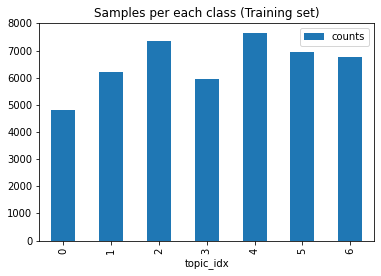

In [7]:
# 작가별 분포도 확인 
train.groupby(train.topic_idx).size().reset_index(name="counts").plot.bar(x='topic_idx',title="Samples per each class (Training set)")

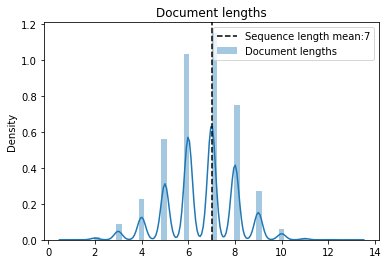

 가장 긴 문장은 13 개의 단어를, 가장 짧은 문장은 1 개의 단어를 가지고 있습니다.


In [8]:
# 문장 길이 분포도 확인
train['doc_len'] = train.title.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {train['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {train['doc_len'].min()} 개의 단어를 가지고 있습니다.")

plot_doc_lengths(train)

### 텍스트 기본 전처리
코드 실행만 해주시고 넘어가시면 됩니다~

In [9]:
train.drop_duplicates(subset=['title'], inplace=True) # 중복값 있다면 제거

In [10]:
train = train.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [11]:
train['title'] = train['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train[:5]

,index,title,topic_idx,doc_len
0,0,인천핀란드 항공기 결항휴가철 여행객 분통,4,5
1,1,실리콘밸리 넘어서겠다구글 조원 들여 전역 거점화,4,6
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,8
3,3,클린턴 측근기업 특수관계 조명공과 사 맞물려종합,4,7
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,7


In [12]:

# 한글만 남긴 이후, 빈 값이 된 행을 제거해줍시다.
train['title'] = train['title'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train['title'].replace('', np.nan, inplace=True)
train = train.dropna(how = 'any')

In [13]:
# test data에 대해서도 같은 과정을 수행해줍니다.
test.drop_duplicates(subset = ['title'], inplace=True) # title 열에서 중복인 내용이 있다면 중복 제거
test['title'] = test['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test['title'] = test['title'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test['title'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test = test.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test))

전처리 후 테스트용 샘플의 개수 : 9131


### 본 과제 시작! Q1~Q7을 채워주세요!

In [14]:
!pip3 install konlpy
from konlpy.tag import Okt

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 448 kB 55.4 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [15]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

In [16]:
# 트레인데이터를 토큰화해주세요!
X_train = []
for sentence in train['title']:
    temp_X = okt.morphs(sentence, stem=True) # Q1. 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # Q2. 불용어 제거
    X_train.append(temp_X)

In [17]:
# Q3. 테스트 데이터도 똑같이 토큰화를 진행해주세요!
X_test = []
for sentence in test['title']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [18]:
vocab_size =2000 # vocabsize는 2000으로 하겠습니다!
tokenizer = Tokenizer(vocab_size)
# Q4. fit_on_texts()를 이용하여 각 단어에 고유한 정수를 부여하고 단어 집합을 생성해주세요~
tokenizer.fit_on_texts(X_train)

In [19]:
# Q5. texts_to_sequence()를 통해 X_train과 X_test의 텍스트 시퀀스를 숫자 시퀀스로 바꿔줍시다!
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
################################################################################

y_train = np.array(train['topic_idx'])
y_train = to_categorical(y_train, 7)

리뷰의 최대 길이 : 15
리뷰의 평균 길이 : 5.935360217291306


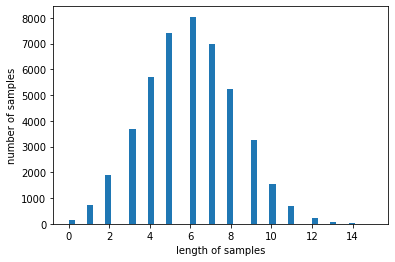

In [20]:
#리뷰 길이 분포 보기
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [21]:
max_len = 10 #위 그래프 확인하시고 적절한 길이 정하시면 됩니다!

##### Q6. pad_sequences 함수 이용해서 패딩 진행해주세요! max_len도 지정해주세요! ######
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [22]:
embedding_dim = 200 #vocab_size와 max_len 파라미터 세팅은 위에서 이미 진행했습니다! 이용해서 모델링 해주세요~

#################### Q7 ####################
# lstm/vanila RNN, 혹은 다른 모델도 상관 없습니다! import 할 거 하시고, 모델링을 해주세요!
# 힌트: 마지막 dense 층에서 출력 뉴런 수, 활성화 함수를 잘 설정하시는게 중요합니다!
# 힌트2: vocab_size와 max_len, embedding_dim 파라미터 이용해서 모델링 해주세요~
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(128))
model.add(Dense(7, activation='sigmoid'))

In [23]:
#학습을 진행시켜봅시다! 셀을 실행시켜주세요! epoch, validation_split은 원하시는대로 바꾸셔도 되고, Early Stopping 응용하셔도 됩니다!
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=5, callbacks=[es, mc], batch_size=100, validation_split=0.2)

Epoch 1/5
366/366 [==============================] - 19s 47ms/step - loss: 0.8638 - acc: 0.6982 - val_loss: 0.9201 - val_acc: 0.6670

Epoch 00001: val_acc improved from -inf to 0.66696, saving model to best_model.h5
Epoch 2/5
366/366 [==============================] - 17s 46ms/step - loss: 0.5435 - acc: 0.8165 - val_loss: 0.8304 - val_acc: 0.7030

Epoch 00002: val_acc improved from 0.66696 to 0.70299, saving model to best_model.h5
Epoch 3/5
366/366 [==============================] - 17s 45ms/step - loss: 0.4892 - acc: 0.8302 - val_loss: 0.8617 - val_acc: 0.6886

Epoch 00003: val_acc did not improve from 0.70299
Epoch 4/5
366/366 [==============================] - 17s 46ms/step - loss: 0.4590 - acc: 0.8408 - val_loss: 0.9317 - val_acc: 0.6665

Epoch 00004: val_acc did not improve from 0.70299
Epoch 5/5
366/366 [==============================] - 17s 46ms/step - loss: 0.4326 - acc: 0.8474 - val_loss: 0.9100 - val_acc: 0.6808

Epoch 00005: val_acc did not improve from 0.70299


<function matplotlib.pyplot.show>

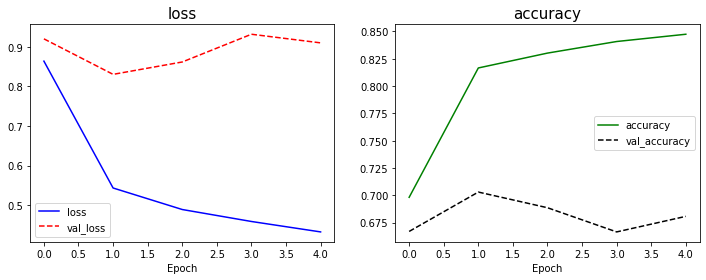

In [24]:
#에러 없이, 원하는 모델로 마지막 epoch까지 학습을 완료시켜주시고 이 셀을 실행시켜주세요! 에러 없이 해당셀까지 실행시켜주시면 성공입니다~

# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy', fontsize= 15)
plt.plot(history.history['acc'], 'g-', label='accuracy')
plt.plot(history.history['val_acc'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

------

**수고하셨습니다🥰🥰🥰**